# PVC IMPORT PATTERN FORECASTING : weekly forecast - feature forecasting

## importing dependencies

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from prophet import Prophet
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

## Function declaration
Following functions are declared in this section
- function for preprocessing
- function for spliting data into train and testing set
- function for prophet model
- function for XGBoost model 

### Data Preprocessing

In [31]:
def preprocess(dset):

    # selecting only required column
    dset = dset[['ds', 'unitp', 'y']]

    # handling missing values with mean fill method
    dset_mean = dset['unitp'].mean()
    dset['unitp'].fillna(dset_mean, inplace=True)

    dset['cost'] = dset['unitp']*dset['y']

    # formatting date column as per datetime format
    dset['ds'] = pd.to_datetime(dset['ds'], format='mixed')
    dset.sort_values(by='ds', inplace=True)

    # resampling dataset to monthwise frequency
    resampled_dataset = dset.groupby(pd.Grouper(key='ds', freq='W')).sum().reset_index()

    # creating lag features
    resampled_dataset['lag_1'] = resampled_dataset['y'].shift(1)
    resampled_dataset.dropna(inplace=True)
    
    return resampled_dataset

### Future Dataset creation: feature forecasting


In [32]:
def future_dset(dset, df):

    # Create a weekly date range from 2024-01-01 to 2024-03-01
    date_range = pd.date_range(start='2025-07-01', end='2025-09-30', freq='7D')

    future_ds = date_range
    future_df = pd.DataFrame(future_ds, columns=['ds'])
    future_df['ds'] = pd.to_datetime(future_df['ds'])
    
    #forecasting future features
    target_list = ['cost', 'lag_1']

    for target in target_list:
        predictor_df = pd.DataFrame()
        predictor_df['ds'] = dset['ds']
        predictor_df['y'] = dset[target]

        model = Prophet(interval_width=0.9)
        model.fit(predictor_df)
        forecast = model.predict(future_df)

        future_df[target] = forecast['yhat']

    future_df.loc[:, 'week'] = future_df['ds'].dt.isocalendar().week
    
    return future_df

### Training and Testing Data Split
- this function takes the dataset to be predicted
- splits the dataset into training and testing dataset
- split is done in 70:30 ratio
- and returns the training, testing and dataset that can be fitted into the model

In [33]:
def train_test_split(df, size):
    split = int(df['ds'].count()*size)
    
    train = df.iloc[:split+1]
    test = df.iloc[split:]
    
    return train, test

### XGBoost :forecasting and plotting
- this function intialises a XGBoost model
- process data for model fitting
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

#### XGBoost model hyperparameters tunning

In [34]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger('xgboost')
logger.setLevel(logging.CRITICAL)

def tunner_xgboost(dset, params):

    split = int(dset['ds'].count()*0.8)
    
    train = dset.iloc[:split+1]
    test = dset.iloc[split:]

    train = train[['ds', 'cost', 'lag_1', 'y']]
    test = test[['ds', 'cost', 'lag_1', 'y']]

    # seggregating features and target for model fitting
    x_train, y_train = train[['ds', 'cost', 'lag_1']], train['y']
    y_test = test[['ds', 'cost', 'lag_1']] 

    # extracting features from datetime columns and droping original datetime column
    x_train.loc[:, 'week'] = x_train['ds'].dt.isocalendar().week
    x_train.drop('ds', axis=1, inplace=True)

    y_test.loc[:, 'week'] = y_test['ds'].dt.isocalendar().week
    y_test.drop('ds', axis=1, inplace=True)

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    model.fit(x_train, y_train)
    
    # forecasting with testing dataset
    forecast = model.predict(y_test)

    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    return mape

def tuning_xgboost(dset):

    dset= dset[['ds', 'cost', 'lag_1', 'y']]

    # hyperparameters search space defination
    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
    n_estimators = [100, 200, 300, 500, 700]
    max_depth = [3, 5, 7, 9, 11]
    objective = ['reg:squarederror', 'reg:absoluteerror']
    eval_metric = ['rmse', 'mae']

    # calculating total combinations to try
    total_combinations = len(learning_rate) * len(n_estimators) * len(max_depth) * len(objective) * len(eval_metric) 

    # setting best mape as infinity and best params as none for future update
    best_mape = float('inf')
    best_params = None

    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning XGBoost", ncols=80) as pbar:
        for em in eval_metric:
            for obj in objective:
                for md in max_depth:
                    for ne in n_estimators:
                        for lr in learning_rate:
                            params = [lr, ne, md, obj, em]
                            try:
                                mape = tunner_xgboost(dset, params)

                                if mape < best_mape:
                                    best_params = params
                                    best_mape = mape

                            except Exception:
                                pass
                            
                            pbar.update(1)
                        
    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    return best_params


#### XGBoost Forecast

In [35]:
def xgboost_forecast(dset, future, name, params):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    # seggregating features and target for model fitting
    x_train, y_train = dset[['week', 'cost', 'lag_1']], dset['y']

    # future date forecasting 
    future_model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    future_model.fit(x_train, y_train)
    future_fit = future[['week', 'cost', 'lag_1']]
    future_forecast = future_model.predict(future_fit)
    future['predicted_y'] = future_forecast

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(dset['ds'], dset['y'], color='orange', label='training data', lw=1)
    plt.plot(future['ds'], future_forecast, color='green', label='test forecast', lw=1)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with hyper-tuned XGBoost')
    plt.tight_layout()
    plt.show()

    future['product_grade'] = name
    future['model_name'] = 'XGBoost'
    return future


## Loadind data and preprocessing

In [ ]:
df = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/fin_PVC_dataset.xlsx') # update file path accordingly
df.rename(columns={'Date': 'ds', 'K Range': 'k', 'Fin Cif ($/MT)': 'unitp', 'Fin QTY (MTs)': 'y'}, inplace=True)
df = df[['ds', 'k', 'unitp', 'y']]

# converting dates to datetime format & sorting
df['ds'] = pd.to_datetime(df['ds'], format='mixed')
df.sort_values(by='ds', inplace=True)

# loading maping dataset
map = pd.read_excel('./Final Versions/datasets/grade_map.xlsx', engine='openpyxl')

# making dictionary of mapping dataset
k_map =  dict(zip(map['k_level'], map['k_code']))

# mapping grades of df to their code from mapping dataset
df['k_code'] = df['k'].map(k_map)

# dropping previous grade column
df.drop('k', axis=1, inplace=True)

# This will store the final forecast results
prophet_forecast_df = pd.DataFrame(columns=['ds', 'product_grade', 'upper_range', 'predicted_import', 'lower_range'])
xgb_forecast_df = pd.DataFrame(columns=['ds', 'product_grade', 'upper_range', 'predicted_import', 'lower_range'])

print(df)
print('Total import: ',df['y'].sum())

              ds  unitp        y  k_code
0     2019-04-01  960.0  193.600     2.0
68    2019-04-01  960.0   90.000     1.0
67    2019-04-01  865.4  144.100     2.0
66    2019-04-01  864.4    8.200     2.0
65    2019-04-01  850.4  222.800     2.0
...          ...    ...      ...     ...
98221 2025-06-30  676.0   10.198     2.0
97911 2025-06-30  684.0  280.000     2.0
98293 2025-06-30  665.0  112.000     2.0
98220 2025-06-30  676.0   12.398     2.0
98199 2025-06-30  676.0  117.404     2.0

[100127 rows x 4 columns]
Total import:  13013663.02607419


## Forecasting individual K-Level

In [37]:
def k_level_forecast(code, name,x_params):   
    dset = df[(df['k_code'] == code)]
    
    # preprocessing and resampling the dataset
    resampled_dset = preprocess(dset)

    # making dataset with future dates and features to make final forecast
    future_df = future_dset(resampled_dset, df)

    if (x_params == None):
        xgboost_params = tuning_xgboost(resampled_dset)
    else:
        xgboost_params = x_params

    xgb_forecast = xgboost_forecast(resampled_dset, future_df, name, xgboost_params)
    print('XGBoost output: ')
    print(xgb_forecast)
    
    return xgb_forecast
    


### Very High K

16:00:59 - cmdstanpy - INFO - Chain [1] start processing
16:00:59 - cmdstanpy - INFO - Chain [1] done processing
16:01:00 - cmdstanpy - INFO - Chain [1] start processing
16:01:01 - cmdstanpy - INFO - Chain [1] done processing


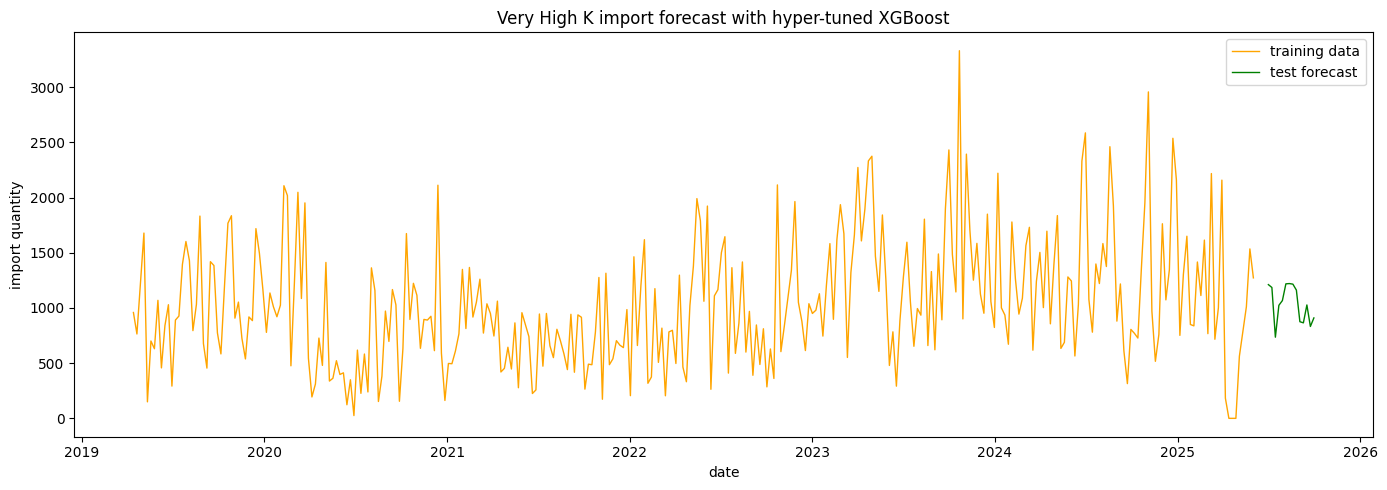

XGBoost output: 
           ds          cost        lag_1  week  predicted_y product_grade  \
0  2025-07-01  1.093429e+06  1152.943137    27  1211.165894   Very High K   
1  2025-07-08  1.133316e+06  1296.696049    28  1185.261353   Very High K   
2  2025-07-15  1.038367e+06  1318.632471    29   735.039917   Very High K   
3  2025-07-22  9.413641e+05  1226.728525    30  1023.733398   Very High K   
4  2025-07-29  9.704917e+05  1160.092736    31  1066.470215   Very High K   
5  2025-08-05  1.099714e+06  1230.022521    32  1218.163452   Very High K   
6  2025-08-12  1.176164e+06  1384.278532    33  1220.636841   Very High K   
7  2025-08-19  1.097141e+06  1459.754570    34  1215.500854   Very High K   
8  2025-08-26  9.296636e+05  1369.173431    35  1161.542603   Very High K   
9  2025-09-02  8.300079e+05  1202.503229    36   875.329163   Very High K   
10 2025-09-09  8.597014e+05  1120.379024    37   864.978149   Very High K   
11 2025-09-16  9.213022e+05  1166.719184    38  1026.929443

In [38]:
xgb_params = [0.1, 200, 11, 'reg:squarederror', 'rmse']
forecast = k_level_forecast(1, 'Very High K',xgb_params) 
xgb_forecast_df = forecast

### High K

16:01:03 - cmdstanpy - INFO - Chain [1] start processing
16:01:03 - cmdstanpy - INFO - Chain [1] done processing
16:01:04 - cmdstanpy - INFO - Chain [1] start processing
16:01:05 - cmdstanpy - INFO - Chain [1] done processing


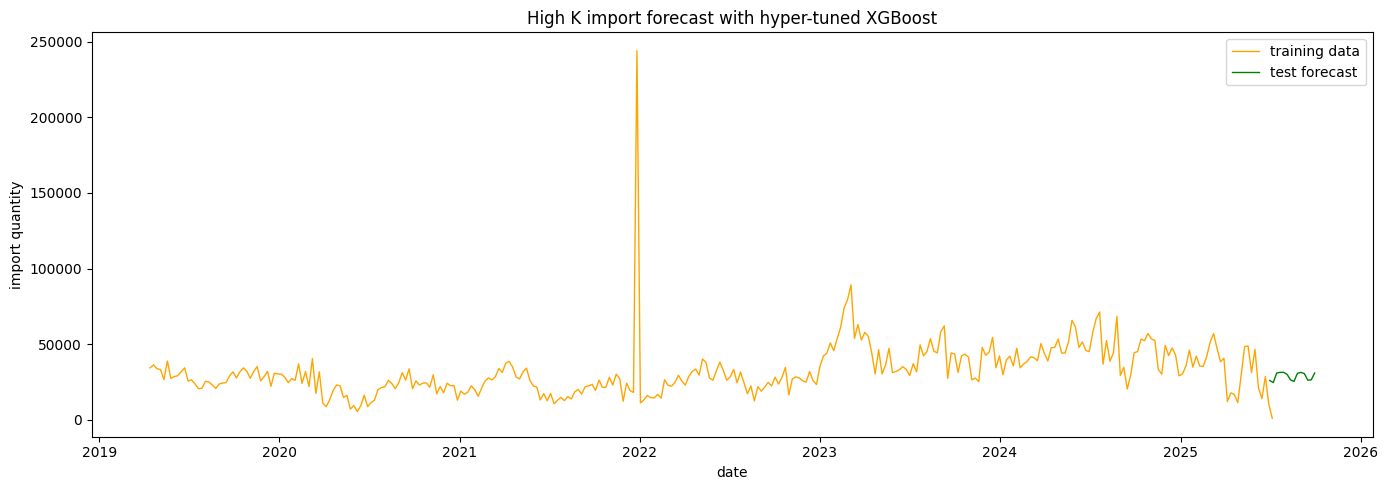

XGBoost output: 
           ds          cost         lag_1  week   predicted_y product_grade  \
0  2025-07-01  2.260057e+07  34291.742887    27  25857.328125        High K   
1  2025-07-08  2.308711e+07  34770.305932    28  24490.601562        High K   
2  2025-07-15  2.508369e+07  36151.840845    29  30784.244141        High K   
3  2025-07-22  2.690771e+07  38262.282775    30  31263.802734        High K   
4  2025-07-29  2.664399e+07  39788.032138    31  31241.884766        High K   
5  2025-08-05  2.445780e+07  39401.726150    32  29979.818359        High K   
6  2025-08-12  2.264992e+07  37527.808537    33  26289.904297        High K   
7  2025-08-19  2.306831e+07  36270.028965    34  25213.507812        High K   
8  2025-08-26  2.489682e+07  37115.295421    35  30605.650391        High K   
9  2025-09-02  2.561973e+07  39049.286499    36  31226.527344        High K   
10 2025-09-09  2.412084e+07  39595.500425    37  30445.023438        High K   
11 2025-09-16  2.213817e+07  37793.

In [39]:
xgb_params = [0.3, 700, 11, 'reg:squarederror', 'rmse']
forecast = k_level_forecast(2, 'High K', xgb_params)
xgb_forecast_df = pd.concat([xgb_forecast_df, forecast], ignore_index=True)

### Medium K

16:01:08 - cmdstanpy - INFO - Chain [1] start processing
16:01:09 - cmdstanpy - INFO - Chain [1] done processing
16:01:09 - cmdstanpy - INFO - Chain [1] start processing
16:01:10 - cmdstanpy - INFO - Chain [1] done processing


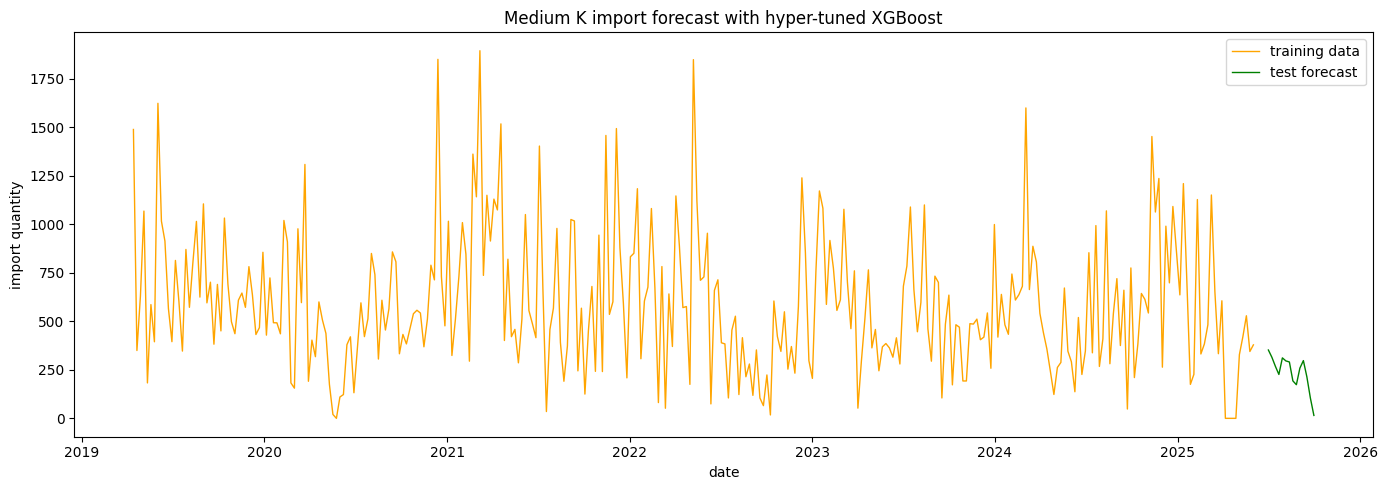

XGBoost output: 
           ds           cost       lag_1  week  predicted_y product_grade  \
0  2025-07-01  273639.380178  399.207486    27   352.031769      Medium K   
1  2025-07-08  249856.319370  430.787887    28   314.673187      Medium K   
2  2025-07-15  209920.123168  440.048642    29   268.179260      Medium K   
3  2025-07-22  201788.388019  432.721836    30   226.082443      Medium K   
4  2025-07-29  232888.187220  435.216144    31   311.464142      Medium K   
5  2025-08-05  259322.346691  456.681172    32   295.826447      Medium K   
6  2025-08-12  241291.775903  474.820540    33   290.503021      Medium K   
7  2025-08-19  195703.174359  465.200142    34   192.934586      Medium K   
8  2025-08-26  176811.568838  435.967006    35   173.286041      Medium K   
9  2025-09-02  204753.144811  420.234886    36   258.724426      Medium K   
10 2025-09-09  231193.988928  432.003298    37   297.441864      Medium K   
11 2025-09-16  191417.098293  441.543464    38   213.507141

In [40]:
xgb_params = [0.3, 500, 3, 'reg:absoluteerror', 'rmse']
forecast = k_level_forecast(3, 'Medium K', xgb_params)
xgb_forecast_df = pd.concat([xgb_forecast_df, forecast], ignore_index=True)

### Low K

16:01:12 - cmdstanpy - INFO - Chain [1] start processing
16:01:12 - cmdstanpy - INFO - Chain [1] done processing
16:01:13 - cmdstanpy - INFO - Chain [1] start processing
16:01:14 - cmdstanpy - INFO - Chain [1] done processing


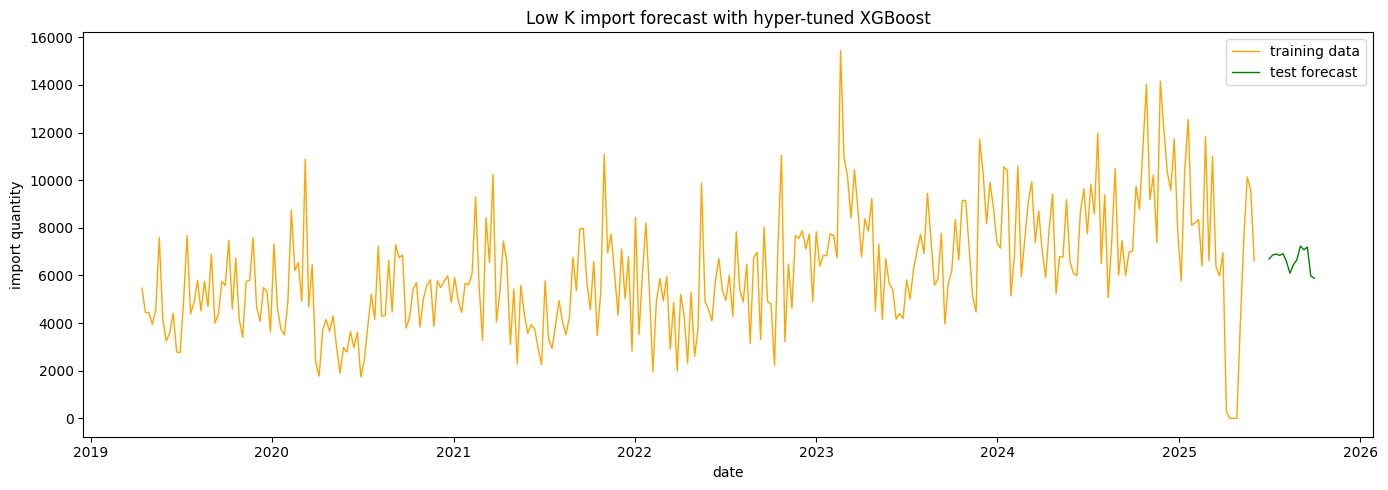

XGBoost output: 
           ds          cost        lag_1  week  predicted_y product_grade  \
0  2025-07-01  5.341164e+06  6993.954894    27  6691.486816         Low K   
1  2025-07-08  5.530990e+06  7406.269904    28  6854.122559         Low K   
2  2025-07-15  5.696401e+06  7746.439122    29  6903.034180         Low K   
3  2025-07-22  5.891487e+06  8036.413179    30  6838.375000         Low K   
4  2025-07-29  5.997533e+06  8307.646101    31  6913.241211         Low K   
5  2025-08-05  5.867841e+06  8457.897659    32  6581.859375         Low K   
6  2025-08-12  5.582387e+06  8360.894339    33  6097.357910         Low K   
7  2025-08-19  5.452060e+06  8096.053497    34  6446.918457         Low K   
8  2025-08-26  5.698701e+06  7961.555936    35  6655.315430         Low K   
9  2025-09-02  6.157482e+06  8175.994285    36  7237.342773         Low K   
10 2025-09-09  6.380940e+06  8588.524429    37  7080.696289         Low K   
11 2025-09-16  6.091260e+06  8778.255958    38  7188.382812

In [41]:
xgb_params = [0.3, 700, 3, 'reg:absoluteerror', 'rmse']
forecast = k_level_forecast(4, 'Low K',xgb_params)
xgb_forecast_df = pd.concat([xgb_forecast_df, forecast], ignore_index=True)

In [42]:
xgb_forecast_df.to_excel('xgboost_forecast_forecasted_features_JULY_SEPT.xlsx', index=False)